In [1]:
%matplotlib inline

In [23]:
import numpy as np
import pandas as pd

Use the following data generating process to answer each of the following questions:

In [3]:
N = 10000

z1 = np.random.normal(size=N)
z2 = np.random.normal(size=N)

p_d = 1. / (1. + np.exp(-(z1 + z2)))
d = np.random.binomial(1, p=p_d)

y0 = np.random.normal(z1 + z2)
y1 = y0 + (z1 + z2)**2. + 1.
y = (d==0) * y0 + (d==1) * y1

df = pd.DataFrame({'z1': z1, 'z2': z2, 'd': d, 'y': y, 'y1': y1, 'y0': y0})

In [4]:
df.corr()

,z1,z2,d,y,y1,y0
z1,1.000000,0.004913,0.381305,0.568586,0.284009,0.574164
z2,0.004913,1.000000,0.363188,0.583229,0.286727,0.588744
d,0.381305,0.363188,1.000000,0.610646,0.207459,0.425639
y,0.568586,0.583229,0.610646,1.000000,0.729131,0.822130
y1,0.284009,0.286727,0.207459,0.729131,1.000000,0.509059
y0,0.574164,0.588744,0.425639,0.822130,0.509059,1.000000


## 1. For this data generating process,

a) Is there a set of covariates, $Z$, that satisfies the back-door criterion for the effect of $d$ on $y$?



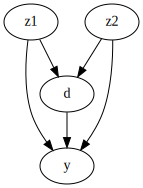

In [26]:
from causalgraphicalmodels import CausalGraphicalModel
G = CausalGraphicalModel(
    nodes=['z1', 'z2', 'd', 'y'],
    edges=[
        ('z1', 'd'),
        ('z2', 'd'),
        ('z1', 'y'),
        ('z2', 'y'),
        ('d', 'y')
    ]
)
G.draw()

In [29]:
G.get_all_backdoor_adjustment_sets('d', 'y')

frozenset({frozenset({'z1', 'z2'})})

Yes. The set $Z = {z1, z2}$ block the back-door paths $d \leftarrow z1 \rightarrow y$, and $d \leftarrow z2 \rightarrow y$.

b) What is the true ATE?

It's the expected value of $Y_1 - Y_0$, which is $E[1 + (z_1 + z_2)^2] = 3.03$

In [5]:
((z1 + z2)**2. + 1.).mean()

3.042201607411307

## 2. For a back-door set $Z$ for this process, 

a) determine whether the requirement $P(Z, d) > 0$ is satisfied. 

b) Why is this a requirement for estimating the ATE of $d$ on $y$? 

c) What can we do if it isn't satisfied (hint: is there a CATE we might still care about?)?

d
0    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
1    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
dtype: object

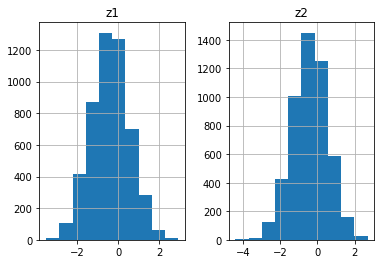

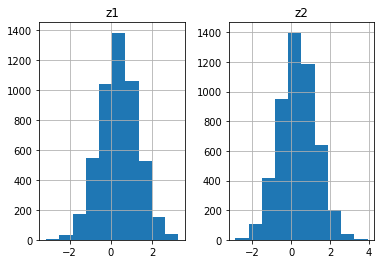

In [30]:
# 2.a We can look at P(Z|d), which will be a little easier.

df[['z1','z2', 'd']].groupby('d').hist()

Visually it looks like there's good support overlap. We can also check the data directly:

In [7]:
df[['z1','z2', 'd']].groupby('d').describe()

z1                                                              \
    count      mean       std       min       25%       50%       75%   
d                                                                       
0  5044.0 -0.381505  0.927005 -3.487244 -1.002230 -0.370300  0.237676   
1  4956.0  0.380674  0.920895 -3.151905 -0.245305  0.389748  0.997128   

                 z2                                                    \
        max   count      mean       std       min       25%       50%   
d                                                                       
0  2.919922  5044.0 -0.394660  0.952755 -4.407524 -1.024635 -0.386480   
1  3.285680  4956.0  0.343407  0.940639 -2.869097 -0.299962  0.336131   

                       
        75%       max  
d                      
0  0.247627  2.698753  
1  0.975034  3.931089

So we can see the distributions don't overlap especially well. 


**2 b** : This is a requirement because we need to observe treatment and control cases at the same levels of Z so we can match units. Alternatively, because the do() operation requires division by P(D, Z), so we need it to be nonzero so the do() operation is defined.

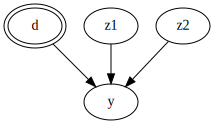

In [31]:
G_do = G.do('d')
G_do.draw()


**2 c**: We can proceed in two ways:

1. avoid the problem by assuming our model for P(d|Z) extrapolates into the region for which we have no data, or
2. constrain the data to the region of support overlap, and measure the ATE conditional on z1 and z2 falling within this region.

I'll take the second approach below.

## 3.  Propensity score matching: Using R or Python, 

a) use propensity score matching to estimate the treatment effect (an ATE or CATE) of $d$ on $y$.

b) explain whether you achieved good balance on the covariates and on the propensity scores

3a) I'll use the causality package to do the matching.

In [32]:
from causality.estimation.parametric import PropensityScoreMatching

matcher = PropensityScoreMatching()

# the most trivial version is to esimate the ATE directly:

matcher.estimate_ATE(df, 'd', 'y', {'z1': 'c', 'z2': 'c'})

Optimization terminated successfully.
         Current function value: 0.531782
         Iterations 6


/home/eric/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2.9616322235652555

but we can also score, then match.

In [9]:
scored = matcher.score(df, {'z1': 'c', 'z2': 'c'}, 'd')

Optimization terminated successfully.
         Current function value: 0.531782
         Iterations 6


In [10]:
scored.sample(10)

,z1,z2,d,y,y1,y0,propensity score
384,0.274844,-0.573587,1,1.844539,1.844539,0.755292,0.431242
5590,0.857617,0.823512,1,6.433650,6.433650,2.607457,0.848809
4691,-0.936347,0.064845,0,0.188861,1.948378,0.188861,0.286053
2621,1.068273,0.337744,1,4.160124,4.160124,1.183240,0.812068
4558,0.465942,-0.953846,0,0.367596,1.605646,0.367596,0.388367
3794,0.318499,0.609932,0,3.295629,5.157613,3.295629,0.720368
1812,0.920350,0.427149,1,3.122357,3.122357,0.306605,0.801704
6758,-0.396997,0.087476,0,0.364749,1.460552,0.364749,0.419383
8685,-0.454331,-0.665772,0,0.930970,3.185600,0.930970,0.243280
5005,-1.184403,0.274504,1,0.132426,0.132426,-1.695490,0.275523


Let's check the imbalance before matching ...

In [11]:
matcher.assess_balance(df, 'd', {'z1': 'c', 'z2': 'c'})

{'z1': 0.8249090544465013, 'z2': 0.779607649928028}

Now we'll match and check again ...

In [12]:
treated, matched_controls = matcher.match(df, 'd', match_to='treated')
matched = pd.concat([treated, matched_controls])
matcher.assess_balance(matched, 'd', {'z1': 'c', 'z2': 'c'})

/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


{'z1': -0.005015641927506125, 'z2': 0.007678514972785846}

Much better!

Now, let's estimate the ATT with these.

In [13]:
att = (treated['y'] - matched_controls['y']).mean()
att

2.938731927071378

In [14]:
matched_treated, controls = matcher.match(df, 'd', match_to='control')
matched = pd.concat([matched_treated, controls])
matcher.assess_balance(matched, 'd', {'z1': 'c', 'z2': 'c'})

/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


{'z1': -0.017031448035861648, 'z2': 0.02519326308588352}

In [15]:
atc = (matched_treated['y'] - controls['y']).mean()
atc

2.9851494089728385

In [16]:
p_d = df['d'].mean()
p_d

0.4956

In [17]:
ate = p_d * att + (1-p_d) * atc
ate

2.9621449049424746

Pretty good!

## 4. Weighted regression: Using R or Python, 

a) use inverse propensity weighted regression to estimate the same treatement effect as in (3), but don't use doubly robust regression yet. (Hint: the data generating process isn't linear. Be careful about your regression specification!)

b) Use a doubly robust estimator to estimate the treatment effect.

4a) We already have the propensity scores, so we just need to make a WLS regression. statsmodels has a good implementation.


In [18]:
df.sample(10)

,z1,z2,d,y,y1,y0,propensity score
3629,-0.635360,0.789607,0,1.050566,2.074358,1.050566,0.530604
9582,0.572333,0.889176,1,4.883489,4.883489,1.747484,0.816198
8856,-0.221257,-0.458663,0,-0.564014,0.898278,-0.564014,0.335405
7256,-0.887068,2.112991,1,3.453899,3.453899,0.951012,0.763932
7008,1.128232,1.387464,1,9.481065,9.481065,2.152341,0.928947
8604,-1.299162,-0.871858,0,-2.323566,3.389761,-2.323566,0.097298
7557,0.115440,-0.745730,1,0.967445,0.967445,-0.429820,0.350799
6762,-0.762260,0.033593,0,0.194120,1.725076,0.194120,0.318046
4320,-0.331401,1.045431,1,2.962457,2.962457,1.452618,0.667403
2257,-3.068234,0.059403,0,-3.171552,6.881516,-3.171552,0.040680


In [19]:
from statsmodels.api import WLS

In [20]:
weights = 1. / ((df['d']*df['propensity score']) + (1-df['d'])*(1 - df['propensity score']))
df['intercept'] = 1.
model = WLS(df['y'], df[['d', 'intercept']], weights=weights)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.240
Model:                            WLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     3160.
Date:                Thu, 20 Dec 2018   Prob (F-statistic):               0.00
Time:                        10:45:55   Log-Likelihood:                -24484.
No. Observations:               10000   AIC:                         4.897e+04
Df Residuals:                    9998   BIC:                         4.899e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
d              2.9024      0.052     56.216      0.000       2.801       3.004
intercept      0.0164      0.036      0.452      0.651      -0.055       0.088
==============================================================================
Omnibus:                     4872.822   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48996.386
Skew:                           2.104   Prob(JB):                         0.00
Kurtosis:                      12.994   Cond. No.                         2.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

not bad! We can be a little smarter by also regression on the covariates, for a doubly robust estimator.

In [21]:
weights = 1. / ((df['d']*df['propensity score']) + (1-df['d'])*(1 - df['propensity score']))
df['intercept'] = 1.
model = WLS(df['y'], df[['d', 'z1', 'z2', 'intercept']], weights=weights)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.500
Model:                            WLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     3338.
Date:                Thu, 20 Dec 2018   Prob (F-statistic):               0.00
Time:                        10:45:55   Log-Likelihood:                -22387.
No. Observations:               10000   AIC:                         4.478e+04
Df Residuals:                    9996   BIC:                         4.481e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
d              2.9126      0.042     69.565      0.000       2.831       2.995
z1             1.0137      0.021     48.897      0.000       0.973       1.054
z2             1.0881      0.021     52.242      0.000       1.047       1.129
intercept      0.0086      0.029      0.290      0.771      -0.049       0.066
==============================================================================
Omnibus:                     9944.972   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1652609.538
Skew:                           4.465   Prob(JB):                         0.00
Kurtosis:                      65.342   Cond. No.                         2.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

or even smarter by using the right specification, with a quadratic term.

In [22]:
df['z1z2'] = (df['z1'] + df['z2'])**2.
df['intercept'] = 1.
weights = 1. / ((df['d']*df['propensity score']) + (1-df['d'])*(1 - df['propensity score']))
model = WLS(df['y'], df[['d', 'z1z2', 'intercept']], weights=weights)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.419
Model:                            WLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     3606.
Date:                Thu, 20 Dec 2018   Prob (F-statistic):               0.00
Time:                        10:45:55   Log-Likelihood:                -23141.
No. Observations:               10000   AIC:                         4.629e+04
Df Residuals:                    9997   BIC:                         4.631e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
d              3.0068      0.045     66.545      0.000       2.918       3.095
z1z2           0.4363      0.008     55.493      0.000       0.421       0.452
intercept     -0.9360      0.036    -25.922      0.000      -1.007      -0.865
==============================================================================
Omnibus:                      665.856   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3046.661
Skew:                           0.131   Prob(JB):                         0.00
Kurtosis:                       5.691   Cond. No.                         8.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Realistically, you'd just use a full specification, with each linear z term, quadratic versions, and then the z1*z2 cross term.

In [40]:
df['z1z2'] = (df['z1'] + df['z2'])**2.
df['z1*z2'] = df['z1'] * df['z2']
df['z1^2'] = df['z1']**2
df['z2^2'] = df['z2']**2
df['intercept'] = 1.
weights = 1. / ((df['d']*df['propensity score']) + (1-df['d'])*(1 - df['propensity score']))
model = WLS(df['y'], df[['d', 'z1', 'z2', 'z1^2', 'z2^2', 'z1*z2', 'intercept']], weights=weights)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.656
Model:                            WLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     3172.
Date:                Thu, 20 Dec 2018   Prob (F-statistic):               0.00
Time:                        11:09:49   Log-Likelihood:                -20526.
No. Observations:               10000   AIC:                         4.107e+04
Df Residuals:                    9993   BIC:                         4.112e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
d              3.0076      0.035     86.429      0.000       2.939       3.076
z1             0.9790      0.017     56.820      0.000       0.945       1.013
z2             1.0281      0.017     59.342      0.000       0.994       1.062
z1^2           0.4499      0.012     36.045      0.000       0.425       0.474
z2^2           0.3887      0.013     30.953      0.000       0.364       0.413
z1*z2          0.7892      0.017     46.041      0.000       0.756       0.823
intercept     -0.9038      0.031    -29.551      0.000      -0.964      -0.844
==============================================================================
Omnibus:                     4568.151   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2176239.617
Skew:                          -0.846   Prob(JB):                         0.00
Kurtosis:                      75.250   Cond. No.                         5.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""